## Figure 1

European starling song, tempo measurement, smoothed amplitude envelope

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

In [111]:
from starling_rhythm.utils.paths import DATA_DIR, FIGURE_DIR
from pathlib2 import Path

In [112]:
wav_paths = list(Path(DATA_DIR).rglob("*27-520000.wav"))

In [113]:
wav_paths[0]

PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-13_17-15-27-520000.wav')

In [1123]:
sr, data = read(wav_paths[0])
data = data[5*48000:-5*48000]

## Write amplitude envelope

In [1124]:
from starling_rhythm.utils.audio import extract_amp_env
import numpy as np

In [1125]:
amp_env = extract_amp_env(
    data.astype(np.int16), 
    target_sr = 200, ## each number is 5 ms
    win_type = 'boxcar', ## smooth with boxcar window (rolling average)
    res_type = 'linear', ## linear resample
    stds = 1, ## make compact support
    buffer = 100, ## buffer compact support
    spl = True,
    reduce_noise = True,
    #hilbert_artifacts = True
)

In [1126]:
def normalize(x, normalize_anchors, newRange=(0, 1)): #x is an array. Default range is between zero and one
    xmin, xmax = normalize_anchors #get max and min from input array
    norm = (x - xmin)/(xmax - xmin) # scale between zero and one
    
    if newRange == (0, 1):
        return(norm) # wanted range is the same as norm
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to a different range.    
    #add other conditions here. For example, an error message

## Get smoothed amp_env

In [1127]:
from scipy.signal import hilbert, get_window

In [1128]:
win_type = 'hann'

In [1129]:
smoothed_amp_env = np.convolve(amp_env, get_window(win_type, 1000))
smoothed_amp_env = normalize(smoothed_amp_env, (np.min(smoothed_amp_env), np.max(smoothed_amp_env)), newRange = (0, 1))

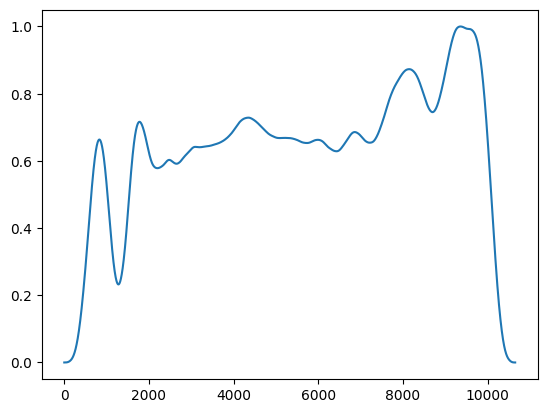

In [1130]:
plt.plot(smoothed_amp_env)

## Try another rhythm

In [1131]:
import numpy as np
from scipy.io.wavfile import read
from avgn.signalprocessing.filtering import butter_bandpass_filter
from starling_rhythm.utils.audio import int16_to_float32
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation, plot_segmented_spec, plot_segmentations

In [1132]:
### segmentation parameters
min_level_db = -100 ## default dB minimum of spectrogram (threshold anything below)
min_level_db_floor = 0 ## highest number min_level_db is allowed to reach dynamically
db_delta = 5 ## delta in setting min_level_db
n_fft = 1024 ## FFT window size
hop_length_ms = 1 ## number audio of frames in ms between STFT columns
win_length_ms = 5 ## size of fft window (ms)
ref_level_db = 20 ## reference level dB of audio
pre = 0.97 ## coefficient for preemphasis filter
spectrogram_range = None ## spectral range to care about for spectrogram
verbose = False ## display output
mask_thresh_std = 0.8 ## standard deviations above median to threshold out noise (higher = threshold more noise)
neighborhood_time_ms = 5 ## size in time of neighborhood-continuity filter
neighborhood_freq_hz = 500 ## size in Hz of neighborhood-continuity filter
neighborhood_thresh = 0.5 ## threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
min_syllable_length_s = 0.075 ## shortest expected length of syllable
min_silence_for_spec = 0.025 ## shortest expected length of silence in a song (used to set dynamic threshold)
silence_threshold = 0.0 ## threshold for spectrogram to consider noise as silence
max_vocal_for_spec = 2.0 ## longest expected vocalization in seconds
temporal_neighbor_merge_distance_ms = 0 ##longest distance at which two elements should be considered one
overlapping_element_merge_thresh = np.inf ##proportion of temporal overlap to consider two elements one
min_element_size_ms_hz = [0,0] ## smallest expected element size (in ms and Hz). Everything smaller is removed
butter_min = 500
butter_max = 15000
figsize = (20,5)

In [1133]:
def segment_spec_custom(address, plot = True):
    
    ## load in wav
    rate, data = read(address)
    
    ## coerce data to float32
    data = int16_to_float32(data)
    
    ## pass data through a filter
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)
    
    ## segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()
        
    return {
        'onsets': results['onsets'], 
        'offsets': results['offsets']
    }

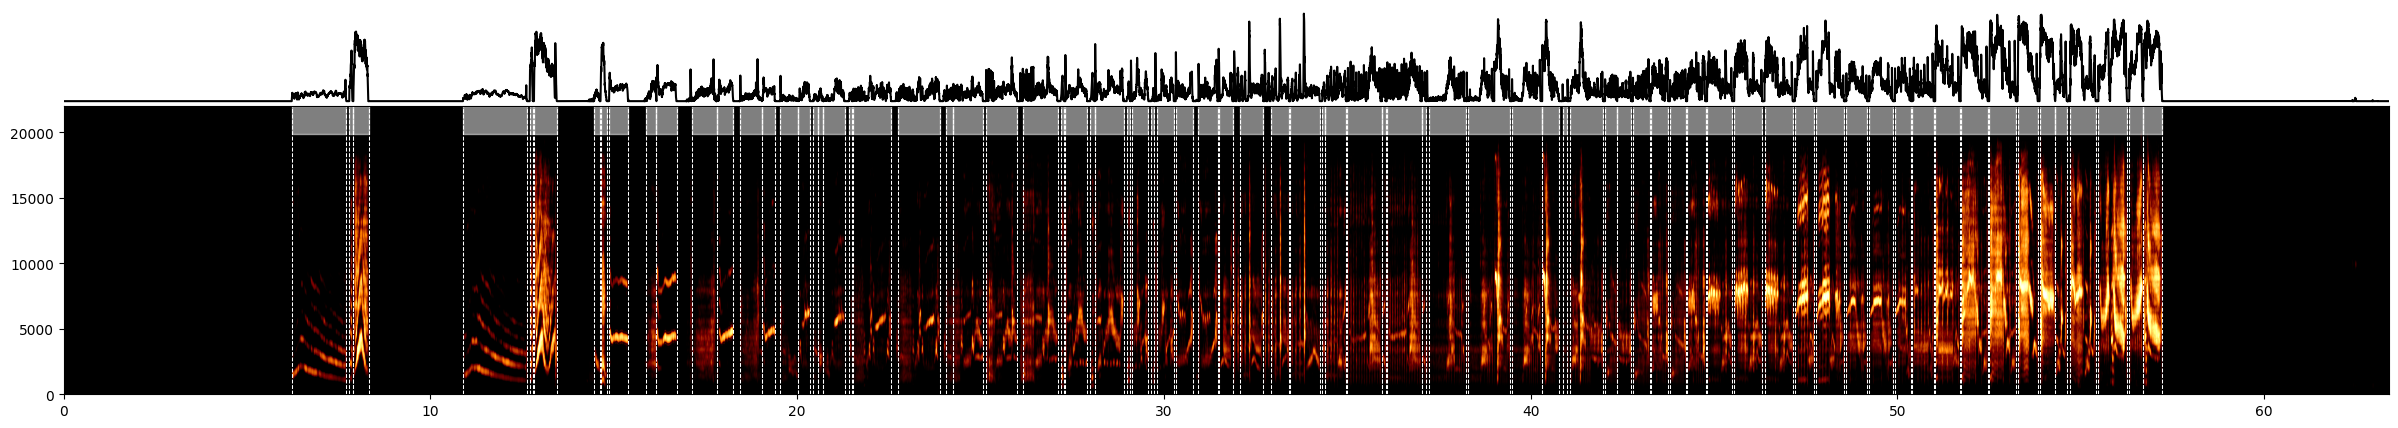

In [1134]:
seg_dict = segment_spec_custom(wav_paths[0])

In [1135]:
tempos = tempo_estimate(seg_dict['onsets'])

In [1136]:
smoothed_tempos = np.convolve(tempos, get_window(win_type, 20))

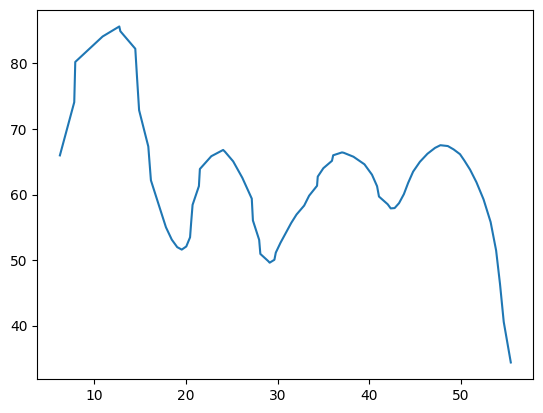

In [1137]:
plt.plot(seg_dict['onsets'][:-2], smoothed_tempos[10:-9])

## get peak event series

In [1138]:
from scipy.signal import find_peaks

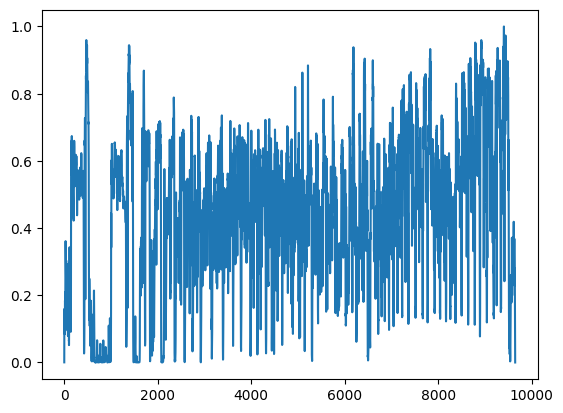

In [1139]:
plt.plot(amp_env)

In [1172]:
peaks, _ = find_peaks(
    amp_env, 
    height = 0.4,
    threshold = 0,
    distance = 1,
    prominence = 0
)

In [1173]:
def tempo_estimate(peaks):
    tempo = []
    for i in np.arange(len(peaks)):
        try:
            tempo.append((peaks[i+2] - peaks[i]))
        except:
            continue
            
    return tempo

In [1174]:
tempos = tempo_estimate(peaks)

In [1175]:
smoothed_tempos = np.convolve(tempos, get_window(win_type, 200), mode = 'same') / 200

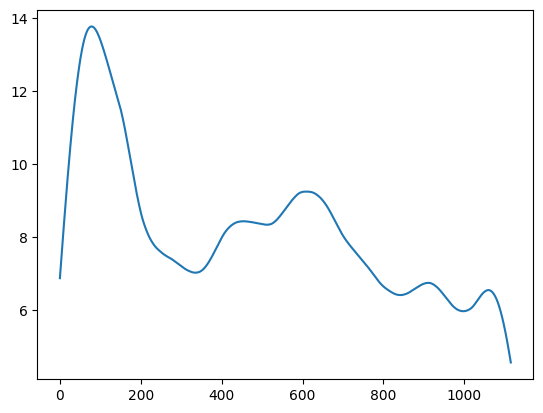

In [1176]:
plt.plot(smoothed_tempos)

## plot

In [1177]:
from numpy import pi

In [1178]:
FIGURE_DIR / 'F1_Starling_qualitative.pdf'

PosixPath('/home/AD/j8xing/starling_rhythm_mfdfa/figures/F1_Starling_qualitative.pdf')

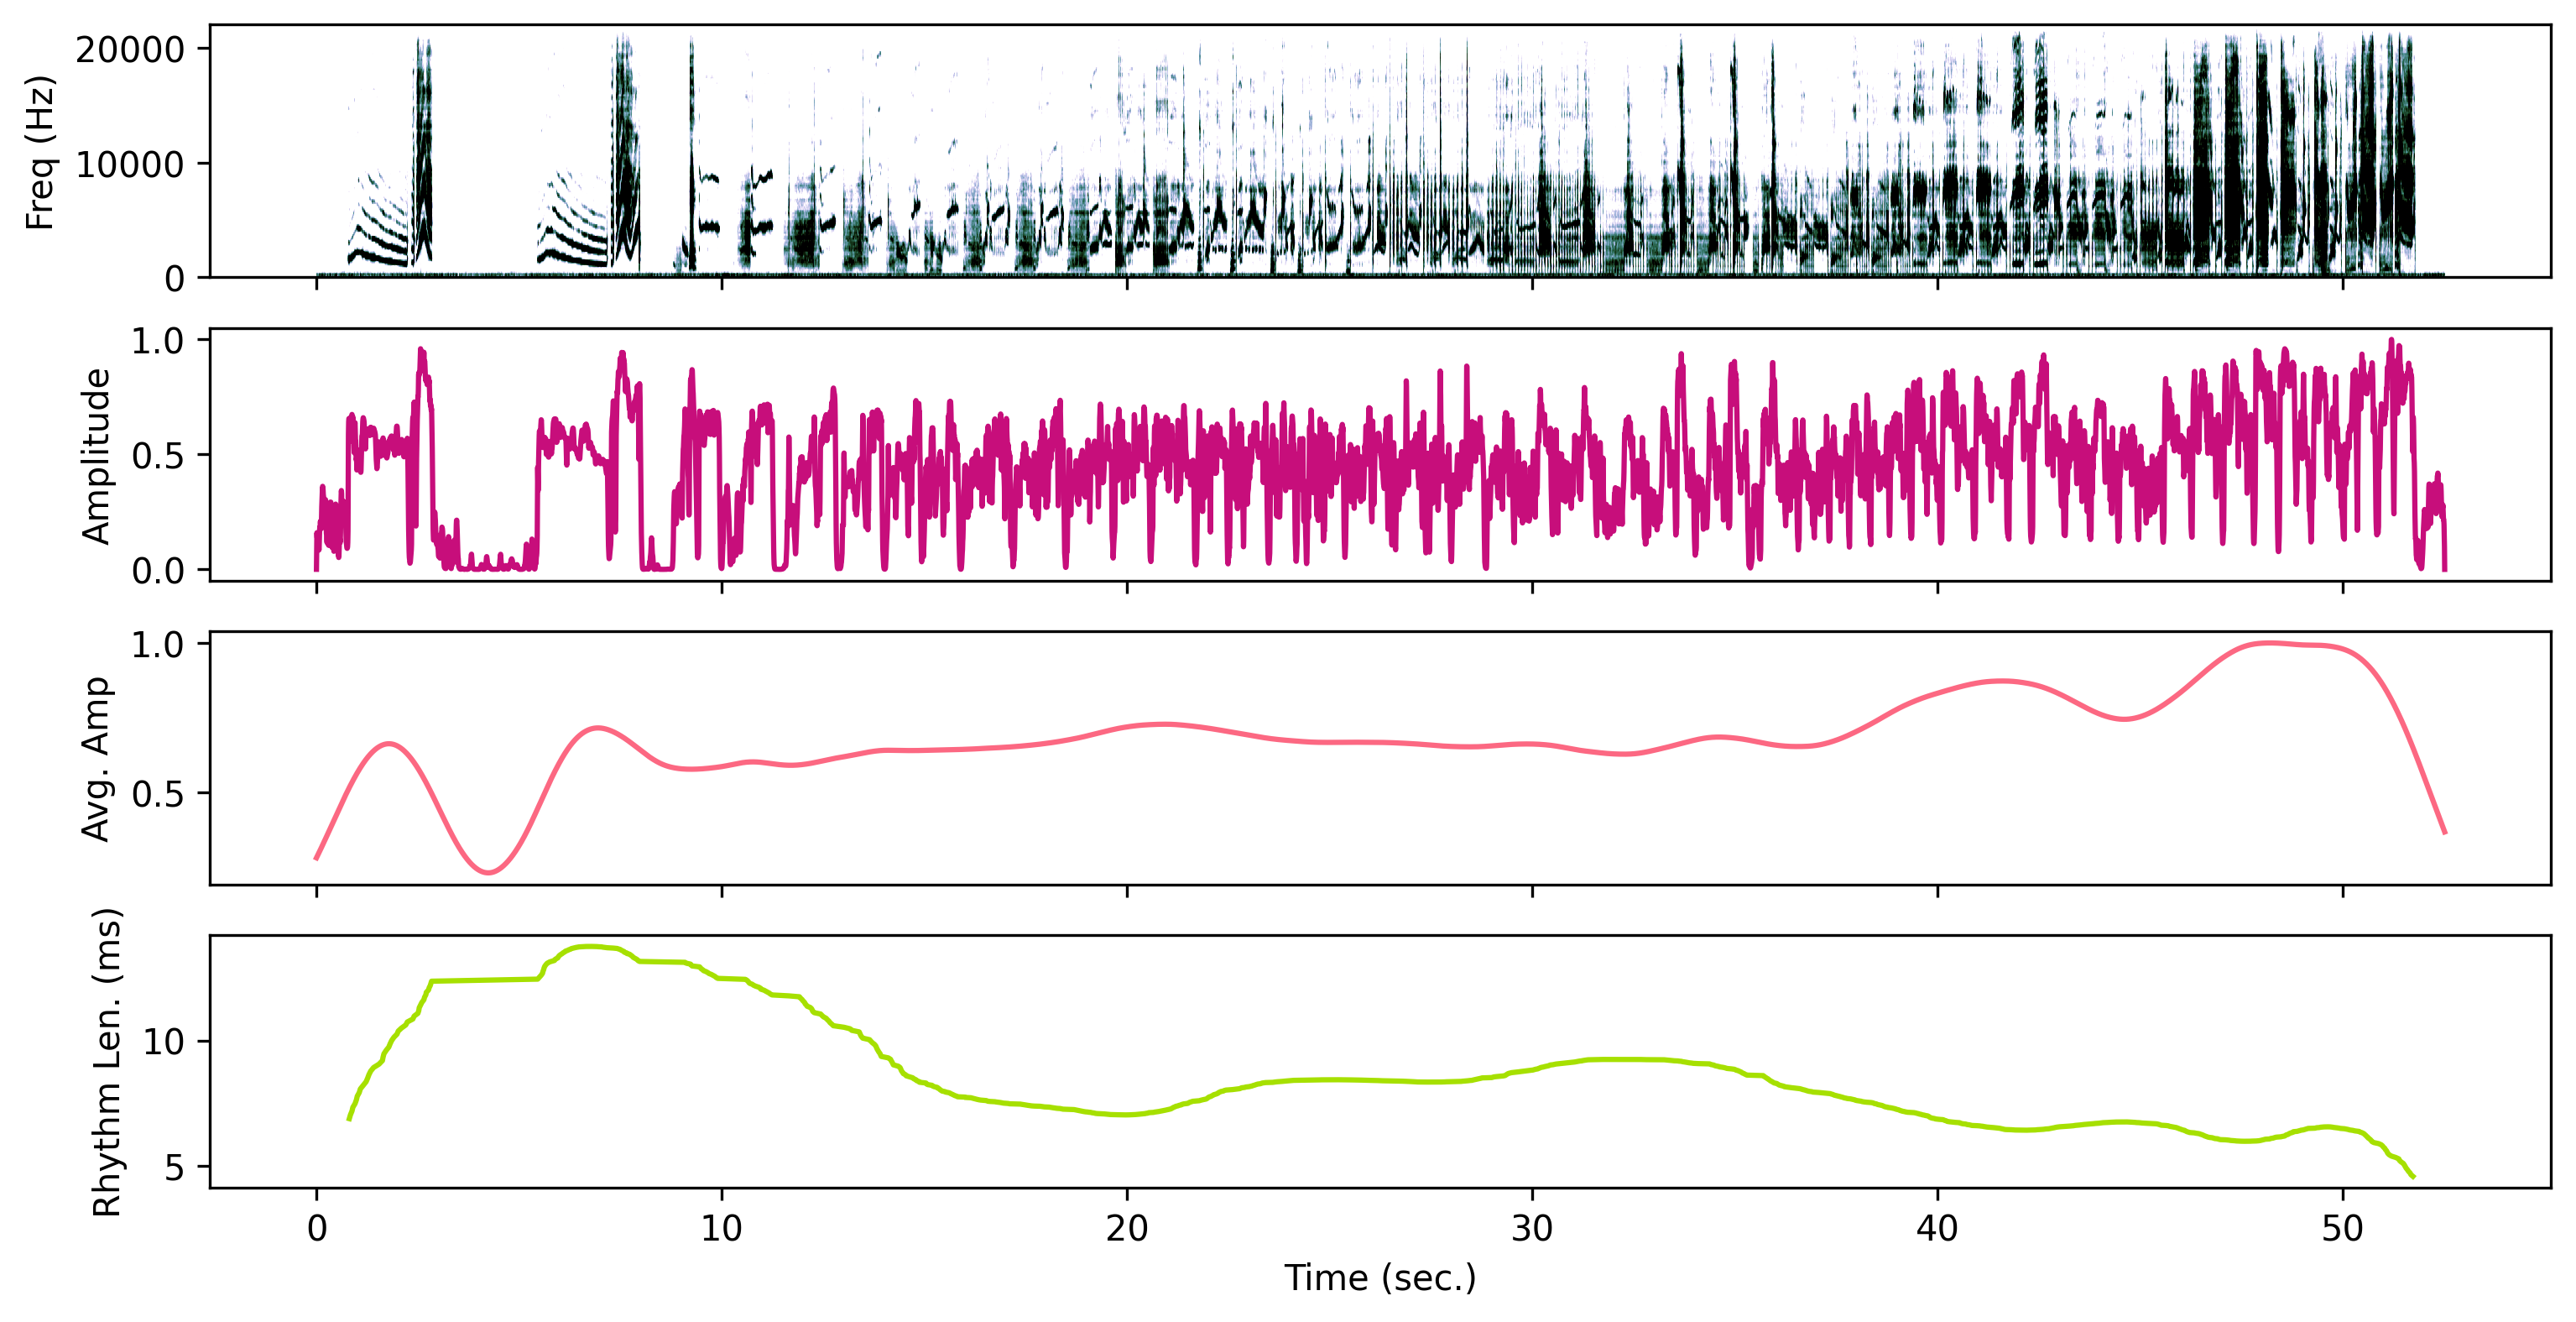

In [1179]:
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (12, 6), dpi = 300, sharex = True)


axes[0].specgram(
    data, Fs = sr, cmap = sns.cubehelix_palette(start = 1.75, rot = 0.5, dark = -2.5, light = 7.5, as_cmap=True)
)
axes[0].set_ylabel('Freq (Hz)')

axes[1].plot(
    np.linspace(0, len(data)/sr, len(amp_env)), amp_env, color = '#C70E7B'
)
axes[1].set_ylabel('Amplitude')

axes[2].plot(
    np.linspace(0, len(data)/sr, len(amp_env)), smoothed_amp_env[500:-499], color = '#FC6882'
)
axes[2].set_ylabel('Avg. Amp')

axes[3].plot(
    normalize(peaks[:-2], normalize_anchors = (0, len(amp_env)), 
              newRange = (0, len(data)/sr)), 
    smoothed_tempos, color = '#A6E000'
)
axes[3].set_ylabel('Rhythm Len. (ms)')
axes[3].set_xlabel('Time (sec.)')

plt.savefig(FIGURE_DIR / 'F1_Starling_qualitative.pdf', dpi = 'figure', format = 'pdf', transparent = True)

## animate

In [1180]:
from matplotlib.animation import FuncAnimation

In [1181]:
# Define the function to update the x-axis limits of the plot
def update(i):
    start = np.round(i * (1/30) - 5, decimals = 1)
    end = np.round(start + 10, decimals = 1)
    axes[0].set_xlim(start, end)
    axes[1].set_xlim(start, end)
    axes[2].set_xlim(start, end)
    axes[3].set_xlim(start, end)

In [1182]:
(len(data)/sr) * 30

1575.1693877551022

In [1183]:
frames

1575

In [1184]:
# Create the animation using FuncAnimation
fps = 30
frames = int((len(data)/sr) * fps)

ani = FuncAnimation(fig, update, frames=range(frames), interval=1000/fps, blit=False)

In [1185]:
%%time
# Save the animation as an mp4 video file
ani.save(FIGURE_DIR / 'F1_Starling_qualitative.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

CPU times: user 11min 12s, sys: 13.4 s, total: 11min 25s
Wall time: 11min 42s
